## If fetching data from Google Drive
My model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Dataset

In [0]:
%%time
!unzip -qq '/content/gdrive/My Drive/modest_museum_dataset/modest_museum_dataset.zip' -d .

CPU times: user 752 ms, sys: 117 ms, total: 869 ms
Wall time: 6min 57s


# Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import PIL
import numpy as np
import random

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Import Packages

In [0]:
from deepnet.data.dataset.modest import ModestMuseum
from deepnet.utils.cuda import initialze_cuda

from deepnet.model.models.model import MaskNet3, DepthMaskNet
from deepnet.model.train import Train

from deepnet.model.losses.loss_combination import BCE_RMSE_LOSS, SSIM_RMSE_LOSS, BCE_SSIM_LOSS, RMSE_SSIM_LOSS, SSIM_DICE_LOSS, RMSE_DICE_LOSS
from deepnet.model.losses.ssim import SSIM, MS_SSIM
from deepnet.model.losses.dice_loss import DiceLoss

from deepnet.utils.plot import Plot
from deepnet.utils.checkpoint import Checkpoint
from deepnet.utils.summary import summary
from deepnet.utils.tensorboard import Tensorboard

# Initialize Cuda

In [5]:
%%time
cuda, device = initialze_cuda(1)

Is CUDA Available? True
CPU times: user 8.05 ms, sys: 17.6 ms, total: 25.7 ms
Wall time: 75.7 ms


## Device Description

In [5]:
!nvidia-smi

Mon May 25 14:55:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
%%time 
modest = ModestMuseum(
    cuda= cuda,
    batch_size = 128,
    num_workers = 16,
    path = 'modest_museum_dataset',
    resize=(64,64),
    train_test_split=0.7,
    seed=1)

CPU times: user 5.63 s, sys: 313 ms, total: 5.94 s
Wall time: 5.95 s


# Dataloader

In [0]:
trainloader = modest.dataloader(train=True)
testloader = modest.dataloader(train=False)

# Dataset Visualization

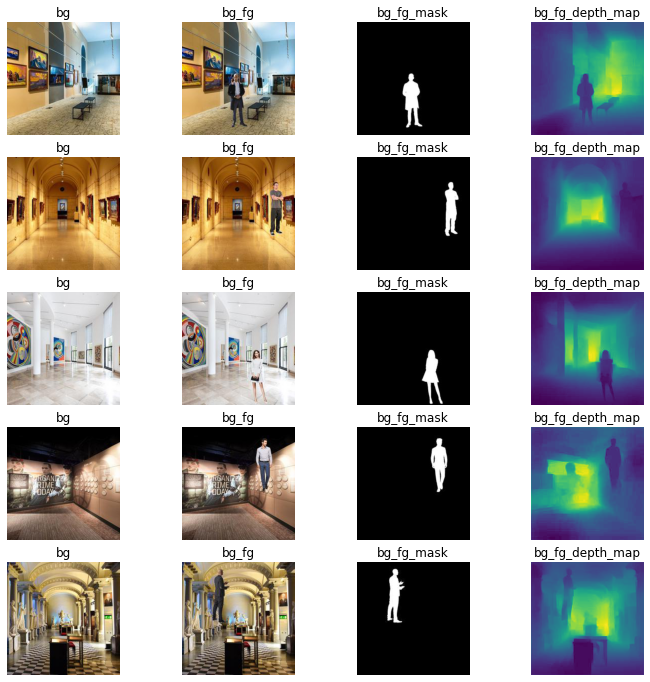

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

columns = 4
rows = 5

images = []
for i in range(rows):
    idx = random.randint(0, len(trainloader))
    batch = trainloader.dataset.dataset[idx]
    images.append(batch['bg'])
    images.append(batch['bg_fg'])
    images.append(batch['bg_fg_mask'])
    images.append(batch['bg_fg_depth'])

fig=plt.figure(figsize=(12,12))


for i in range(1, columns*rows +1):
    img = Image.open(images[i-1])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')

    if images[i-1].split('/')[1] == 'bg':
      plt.title('bg')
      plt.imshow(img)

    elif images[i-1].split('/')[1] == 'bg_fg':
      plt.title('bg_fg')
      plt.imshow(img)

    elif images[i-1].split('/')[1] == 'bg_fg_mask':
      plt.title('bg_fg_mask')
      plt.imshow(img, cmap='gray')

    elif images[i-1].split('/')[1] == 'bg_fg_depth_map':
      plt.title('bg_fg_depth_map')
      plt.imshow(img)

plt.show()

# Model Architecture

In [14]:
%%time
model = DepthMaskNet()
model = model.to(device)
summary(model, {k:v for idx,(k,v) in enumerate(modest.input_size.items()) if idx<2 })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
            Conv2d-7         [-1, 16, 224, 224]             448
       BatchNorm2d-8         [-1, 16, 224, 224]              32
              ReLU-9         [-1, 16, 224, 224]               0
           Conv2d-10         [-1, 16, 224, 224]           2,320
      BatchNorm2d-11         [-1, 16, 224, 224]              32
             ReLU-12         [-1, 16, 224, 224]               0
        MaxPool2d-13         [-1, 16, 112, 112]               0
           Conv2d-14         [-1, 16, 1

# Tensorboard

In [6]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 293), started 1:48:11 ago. (Use '!kill 293' to kill it.)

<IPython.core.display.Javascript object>

# Training
## Modify Learner Class

In [0]:
class ModestTrain(Train):
    def __init__(self):
        return

    def _fetch_data(self, batch, device):
        feature = {}
        feature['bg'] = batch['bg'].to(device)
        feature['bg_fg'] = batch['bg_fg'].to(device)
        
        target = {}
        target['bg_fg_mask'] = batch['bg_fg_mask'].to(device)
        target['bg_fg_depth'] = batch['bg_fg_depth'].to(device)
        return feature, target

    def _fetch_result(self, prediction):
        pred = {
            'bg_fg_mask' : (prediction[0]),
            'bg_fg_depth' : torch.sigmoid(prediction[1])
        }
        return pred

    def _fetch_sigmoid_data(self, prediction):
        pred = {
            'bg_fg_mask' : torch.sigmoid(prediction[0]),
            'bg_fg_depth' : torch.sigmoid(prediction[1])
        }
        return pred
        
modest_train = ModestTrain()

## Optimizer and Scheduler

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-8, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True,
                                                 threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0,
                                                 eps=1e-08)

## Sample Images for Tensorboard

In [17]:
%%time
img_idxes = random.sample(range(len(modest._test_data)), 32)

# Prepare Images
images = {
    'bg': modest._test_data[img_idxes[0]]['bg'].unsqueeze(0),
    'bg_fg': modest._test_data[img_idxes[0]]['bg_fg'].unsqueeze(0)
}

for idx in img_idxes[1:]:
    images['bg'] = torch.cat((
        images['bg'], modest._test_data[idx]['bg'].unsqueeze(0)
    ), 0)
    images['bg_fg'] = torch.cat((
        images['bg_fg'], modest._test_data[idx]['bg_fg'].unsqueeze(0)
    ), 0)


images['bg'] = images['bg'].to(device)
images['bg_fg'] = images['bg_fg'].to(device)

CPU times: user 332 ms, sys: 10.3 ms, total: 342 ms
Wall time: 395 ms


# BCE-RMSE Loss

In [0]:
criterion = BCE_RMSE_LOSS()
checkpoint = Checkpoint('bce_rmse2/checkpoint.pth', monitor='Loss', verbose=1)
tensorboard = Tensorboard('runs/bce_rmse2',images)

In [15]:
%%time
epochs = 3

model.learner(
    0,
    model,
    tensorboard,
    modest_train,
    trainloader,
    testloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 1:
2188/2188 [========] - 1344s 614ms/step|mask_loss: 0.1481|mask_rmse: 4.1831|mask_iou: 0.2769|depth_loss: 0.1481|depth_rmse: 4.1865|depth_iou: 0.2770

 Validation: |mask_loss: 0.096019 |mask_rmse: 7.168 |mask_iou: 0.433 |depth_loss: 0.096019 |depth_rmse: 7.17 |depth_iou: 0.433 


Epoch 00002: Loss improved from inf to 0.00075
Epoch 2:
2188/2188 [========] - 1314s 601ms/step|mask_loss: 0.0856|mask_rmse: 7.5637|mask_iou: 0.4427|depth_loss: 0.0856|depth_rmse: 7.5733|depth_iou: 0.4423

 Validation: |mask_loss: 0.074942 |mask_rmse: 8.392 |mask_iou: 0.462 |depth_loss: 0.074942 |depth_rmse: 8.393 |depth_iou: 0.462 


Epoch 00003: Loss improved from 0.00075 to 0.00062
Epoch 3:
2188/2188 [========] - 1305s 597ms/step|mask_loss: 0.0763|mask_rmse: 8.5299|mask_iou: 0.4683|depth_loss: 0.0763|depth_rmse: 8.5409|depth_iou: 0.4678

 Validation: |mask_loss: 0.071243 |mask_rmse: 9.028 |mask_iou: 0.475 |depth_loss: 0.071243 |depth_rmse: 9.03 |depth_iou: 0.475 


Epoch 00004: Loss improved from 0.

## Training for 128x128

In [0]:
checkpoint = Checkpoint('bce_rmse2/checkpoint.pth', monitor='Loss', verbose=1, last_reload=True)

In [20]:
%%time 

modest = ModestMuseum(
    cuda= cuda,
    batch_size = 128,
    num_workers = 16,
    path = 'modest_museum_dataset',
    resize=(128,128),
    train_test_split=0.7,
    seed=1)

nexttrainloader = modest.dataloader(train=True)
nexttestloader = modest.dataloader(train=False)

CPU times: user 5.71 s, sys: 166 ms, total: 5.88 s
Wall time: 5.89 s


In [21]:
%%time
#epoch 6-9
epochs = 3
model.learner(
    3,
    model,
    tensorboard,
    modest_train,
    nexttrainloader,
    nexttestloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 4:
2188/2188 [========] - 1574s 719ms/step|mask_loss: 0.0681|mask_rmse: 10.1015|mask_iou: 0.4956|depth_loss: 0.0681|depth_rmse: 10.1095|depth_iou: 0.4951

 Validation: |mask_loss: 0.063507 |mask_rmse: 11.669 |mask_iou: 0.507 |depth_loss: 0.063507 |depth_rmse: 11.671 |depth_iou: 0.507 


Epoch 00005: Loss improved from inf to 0.00049
Epoch 5:
2188/2188 [========] - 1606s 734ms/step|mask_loss: 0.0681|mask_rmse: 10.1073|mask_iou: 0.4957|depth_loss: 0.0681|depth_rmse: 10.1153|depth_iou: 0.4952

 Validation: |mask_loss: 0.056736 |mask_rmse: 11.727 |mask_iou: 0.506 |depth_loss: 0.056736 |depth_rmse: 11.73 |depth_iou: 0.506 


Epoch 00006: Loss improved from 0.00049 to 0.00048
Epoch 6:
2188/2188 [========] - 1584s 724ms/step|mask_loss: 0.0681|mask_rmse: 10.1162|mask_iou: 0.4958|depth_loss: 0.0681|depth_rmse: 10.1243|depth_iou: 0.4953

 Validation: |mask_loss: 0.060077 |mask_rmse: 11.731 |mask_iou: 0.506 |depth_loss: 0.060077 |depth_rmse: 11.733 |depth_iou: 0.506 


Epoch 00007: Loss did